# Import csv file

In [2]:
import pandas as pd

df = pd.read_csv('data/csv/data_milknew.csv')

print(df.describe(include='all').to_string())

#ไม่มีข้อมูลขาดหาย

                 pH   Temprature        Taste         Odor         Fat     Turbidity       Colour Grade
count   1059.000000  1059.000000  1059.000000  1059.000000  1059.000000  1059.000000  1059.000000  1059
unique          NaN          NaN          NaN          NaN          NaN          NaN          NaN     3
top             NaN          NaN          NaN          NaN          NaN          NaN          NaN   low
freq            NaN          NaN          NaN          NaN          NaN          NaN          NaN   429
mean       6.630123    44.226629     0.546742     0.432483     0.671388     0.491029   251.840415   NaN
std        1.399679    10.098364     0.498046     0.495655     0.469930     0.500156     4.307424   NaN
min        3.000000    34.000000     0.000000     0.000000     0.000000     0.000000   240.000000   NaN
25%        6.500000    38.000000     0.000000     0.000000     0.000000     0.000000   250.000000   NaN
50%        6.700000    41.000000     1.000000     0.000000     1

In [18]:
print(df.head().to_string())

#คอลัมน์ Grade ยังเป็นตัวอักษร

    pH  Temprature  Taste  Odor  Fat   Turbidity  Colour  Grade
0  6.6          35      1     0     1          0     254      0
1  6.6          36      0     1     0          1     253      0
2  8.5          70      1     1     1          1     246      1
3  9.5          34      1     1     0          1     255      1
4  6.6          37      0     0     0          0     255      2


# Data Preprocessing

## Label encoder

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

print('Grade [high = 0 / low = 1 / medium = 2] :')
df["Grade"] = label_encoder.fit_transform(df["Grade"])
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping = {'Grade': mapping}
print(mapping)

print("  ")

print(df.head().to_string())

#เปลี่ยนจากตัวอักษร object เป็นข้อมูลตัวเลขเพื่อจะนำไปเทรนโมเดล

Grade [high = 0 / low = 1 / medium = 2] :
{'Grade': {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}}
  
    pH  Temprature  Taste  Odor  Fat   Turbidity  Colour  Grade
0  6.6          35      1     0     1          0     254      0
1  6.6          36      0     1     0          1     253      0
2  8.5          70      1     1     1          1     246      1
3  9.5          34      1     1     0          1     255      1
4  6.6          37      0     0     0          0     255      2


## Check balance dataset

Grade
1    429
2    374
0    256 



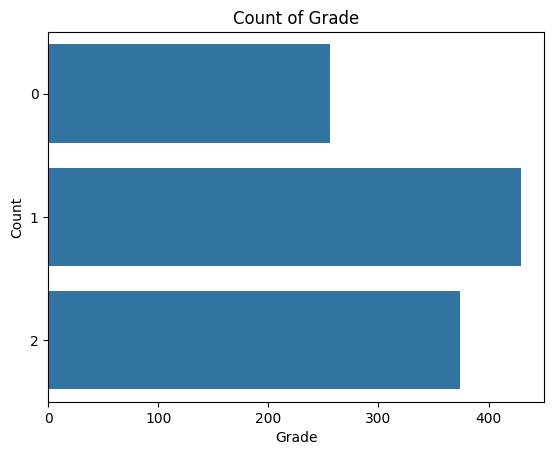

In [20]:
print(df['Grade'].value_counts().to_string(), '\n')

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='Grade', data=df)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count of Grade')

plt.show()

#ทำการเช็คความสมดุลของข้อมูลที่จะเอาไปเทรนโมเดล


## Resampling Dataset

In [6]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

X = df.drop('Grade', axis=1)
y = df['Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

oversampler = RandomOverSampler(sampling_strategy='auto')

X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

#ทำการ resampling จะสุ่มคัดเลือกและทำซ้ำตัวอย่างจากคลาสที่มีจำนวนตัวอย่างน้อย จนกว่าจำนวนตัวอย่างของคลาสที่มีน้อยจะเท่ากับหรือใกล้เคียงกับจำนวนตัวอย่างในคลาสที่มีจำนวนตัวอย่างมาก

## Check balance dataset (again)

Distribution of Grades After Resampling:
1: 287
0: 287
2: 287


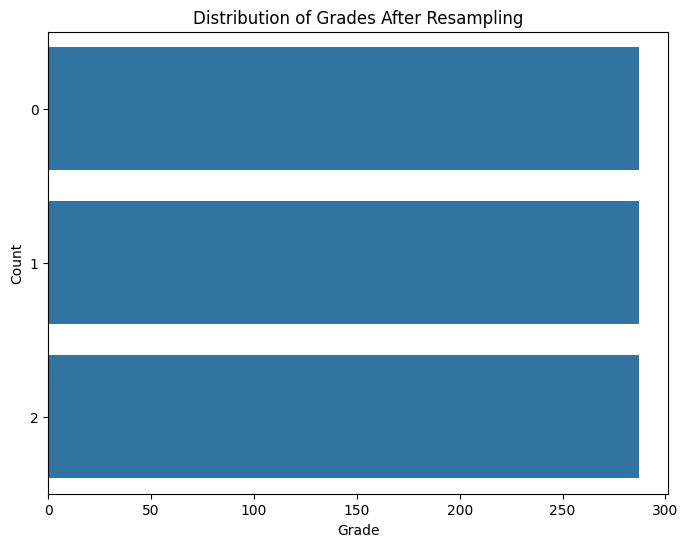

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# นับจำนวนของแต่ละหมวดหมู่ใน y_train_balanced
class_counts = y_train_balanced.value_counts()

# พิมพ์จำนวนของแต่ละหมวดหมู่
print('Distribution of Grades After Resampling:')
for grade, count in class_counts.items():
    print(f'{grade}: {count}')

# สร้าง DataFrame สำหรับการแสดงผล
import pandas as pd
df_balanced = pd.DataFrame({'Grade': y_train_balanced})

# สร้างกราฟแท่ง
plt.figure(figsize=(8, 6))
sns.countplot(y='Grade', data=df_balanced)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Distribution of Grades After Resampling')
plt.show()

#เช็คดูข้อมูลอีกรอบว่าสมดุลหรือยัง

# Save .csv (Toprocess)

In [8]:
# สร้าง DataFrame ใหม่จากข้อมูลที่ปรับขนาดแล้ว
df_resampled_scaled = pd.DataFrame(X_train_balanced, columns=X.columns)
df_resampled_scaled['Grade'] = y_train_balanced.values

# บันทึก DataFrame ลงในไฟล์ CSV
df_resampled_scaled.to_csv('data/csvToprocess/data_milknew_resampled_scaled_data.csv', index=False)

print("Data saved to 'data_milknew_resampled_scaled_data.csv'")

Data saved to 'data_milknew_resampled_scaled_data.csv'


# Model Development  & Hyperparameter Tuning

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#นำเข้าโมเดลต่างๆ

## Set param_grid for Search best tuning model

In [23]:
# Scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

# Create the hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

# Create the hyperparameter grid for K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean
}

# Create the hyperparameter grid for Support Vector Machine (SVM)
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

# Instantiate the models
logreg = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()

# Instantiate the GridSearchCV objects for each model
grid_search_lr = GridSearchCV(estimator=logreg, param_grid=param_grid_lr, cv=5, n_jobs=-1,
                              verbose=2, scoring=scoring, refit='accuracy')

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, n_jobs=-1,
                               verbose=2, scoring=scoring, refit='accuracy')

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1,
                               verbose=2, scoring=scoring, refit='accuracy')

#ทำการกำหนด param_grid เพื่อเก็บ hyperparamiter หลายๆแบบ แล้วใช้ GridSearchCV ค้นหาว่า พารามิเตอร์ตัวไหนดีสุด

## Fit all model

In [11]:
# Fit the GridSearchCV objects
grid_search_lr.fit(X_train_balanced, y_train_balanced)
grid_search_knn.fit(X_train_balanced, y_train_balanced)
grid_search_svm.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_lr = grid_search_lr.predict(X_test)
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_svm = grid_search_svm.predict(X_test)

#ทำการฝึกโมเดลแล้วโดยใช้ พารามิดตอร์ที่ดีสุดและทำการทำนาย

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


## Display result best_param and classification_report

In [12]:
print("_____________________________________________________________", '\n')
# Get and display the best parameters and classification report for each model
print('Logistic Regression Best Parameters:', grid_search_lr.best_params_)
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_lr))
print("_____________________________________________________________", '\n')
print('KNN Best Parameters:', grid_search_knn.best_params_)
print('KNN Classification Report:\n', classification_report(y_test, y_pred_knn))
print("_____________________________________________________________", '\n')
print('SVM Best Parameters:', grid_search_svm.best_params_)
print('SVM Classification Report:\n', classification_report(y_test, y_pred_svm))
print("_____________________________________________________________", '\n')

#แสดงผล hyperparamiter ที่ดีสุดและแสดงค่าการประเมินโมเดล precision / recall / f1-score / support และ accuracy score

_____________________________________________________________ 

Logistic Regression Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.66      0.70        71
           1       0.90      0.74      0.81       142
           2       0.69      0.90      0.78       105

    accuracy                           0.78       318
   macro avg       0.78      0.77      0.76       318
weighted avg       0.79      0.78      0.78       318

_____________________________________________________________ 

KNN Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      1.00      1.00       142
           2       1.00      0.98      0.99       105

    accuracy                           0.9

# Save models (.pkl)

In [13]:
# Import the necessary library for saving models
import joblib

# Dictionary to map the models to their respective GridSearchCV objects
models = {
    'logistic_regression': grid_search_lr,
    'knn': grid_search_knn,
    'svm': grid_search_svm
}

# Loop through the models and save each best model
for model_name, grid_search in models.items():
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'models/best_{model_name}.pkl')
    joblib.dump(mapping, 'models/mapping.pkl')
    joblib.dump(X.columns, 'models/columns.pkl')
    print(f"Saved best {model_name} model to 'models/best_{model_name}.pkl'")


Saved best logistic_regression model to 'models/best_logistic_regression.pkl'
Saved best knn model to 'models/best_knn.pkl'
Saved best svm model to 'models/best_svm.pkl'


# Check mapping variable

In [17]:
mapping_jl = joblib.load('models/mapping.pkl')

# พิมพ์ค่าของ mapping
print(mapping_jl)

{'Grade': {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}}


# Web deployment

#### link : https://predictmilkquality.streamlit.app/